# Example Pytorch Model Using the TIHM Pytorch Dataset:

## Data Loading:

In [84]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data as torchdata

# sklearn imports
from sklearn.utils import compute_sample_weight
from sklearn import metrics

# usual imports
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib.pyplot as plt

# loading dataset
from data_loader import TIHMDataset, TIHM
from data_utils import correct_col_type,gen_date_col,transform_category_to_counts,gen_summary

In [85]:
# Please change the path with the path of your dataset
DPATH = '/content/'
SAVE_PATH = './figs/'

tihm = TIHM(root=DPATH)

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [86]:
## Read all tables into data_dict and generate table summaries

files = os.listdir(DPATH)
data_dict = {}
summaries = {}
for f in files:
    if 'csv' not in f:
        continue
    print(f)
    fpth = os.path.join(DPATH,f)
    df = pd.read_csv(fpth)

    for col in df.columns:
        df[col] = correct_col_type(df,col)

    if 'date' in df.columns:
        df = df.rename(columns={'date':'timestamp'})

    fname = f.split('.')[0]
    data_dict[fname] = df

    summaries[fname] = gen_summary(df)

Sleep.csv
Labels.csv
Physiology.csv
Activity.csv
Demographics.csv


In [87]:
tihm.activity_raw.shape # raw activity data

(1030559, 3)

In [88]:
activity = tihm.activity # aggregated activity data
activity.shape

(2722, 10)

In [89]:
activity.describe()

location_name,date,Back Door,Bathroom,Bedroom,Fridge Door,Front Door,Hallway,Kitchen,Lounge
count,2722,2135.000000,2496.000000,2526.000000,2472.000000,2453.000000,2523.000000,2556.000000,2281.000000
mean,2019-05-29 03:56:28.390888960,22.597658,32.863381,51.913302,44.014159,23.761517,76.886247,88.932707,79.249014
min,2019-04-01 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2019-05-14 00:00:00,7.000000,16.000000,30.000000,23.000000,10.000000,48.500000,59.000000,46.000000
50%,2019-05-31 00:00:00,14.000000,30.000000,44.000000,40.000000,18.000000,73.000000,86.000000,74.000000
75%,2019-06-15 00:00:00,28.000000,46.000000,63.000000,60.000000,30.000000,102.000000,114.000000,108.000000
max,2019-06-30 00:00:00,314.000000,250.000000,264.000000,173.000000,244.000000,264.000000,255.000000,259.000000
std,NaN,25.593749,22.500095,35.156386,26.635970,22.906572,40.083370,41.767526,45.354658


In [90]:
physiology_raw = tihm.physiology_raw
physiology = tihm.physiology

sleep_raw = tihm.sleep_raw
sleep = tihm.sleep

In [91]:
sleep.describe()

,date,heart_rate_mean,heart_rate_std,respiratory_rate_mean,respiratory_rate_std
count,835,835.000000,834.000000,835.000000,834.000000
mean,2019-05-27 07:02:30.898203392,60.684513,4.699769,15.080796,1.661542
min,2019-04-01 00:00:00,46.479691,0.730949,11.649194,0.767287
25%,2019-05-11 00:00:00,56.099285,3.595620,13.924752,1.342108
50%,2019-05-29 00:00:00,60.907692,4.349723,14.678947,1.546222
75%,2019-06-15 00:00:00,64.889231,5.408334,15.682249,1.822515
max,2019-06-30 00:00:00,77.882353,15.470920,20.598055,5.791331
std,NaN,5.887328,1.691474,1.626671,0.523421


In [92]:
data = tihm.data
target = tihm.target

target.describe()

,date,Blood pressure,Agitation,Body water,Pulse,Weight,Body temperature
count,2799,251.000000,114.000000,63.000000,76.000000,4.0,1.0
mean,2019-05-29 11:36:04.630224896,1.215139,1.175439,1.079365,1.250000,1.0,1.0
min,2019-04-01 00:00:00,1.000000,1.000000,1.000000,1.000000,1.0,1.0
25%,2019-05-15 00:00:00,1.000000,1.000000,1.000000,1.000000,1.0,1.0
50%,2019-05-31 00:00:00,1.000000,1.000000,1.000000,1.000000,1.0,1.0
75%,2019-06-16 00:00:00,1.000000,1.000000,1.000000,1.000000,1.0,1.0
max,2019-06-30 00:00:00,4.000000,3.000000,3.000000,5.000000,1.0,1.0
std,NaN,0.538080,0.425838,0.326348,0.613732,0.0,NaN


In [93]:
lbl_df = data_dict['Labels']
lbl_df['timestamp'] = pd.to_datetime(lbl_df['timestamp'])
lbl_df.type.value_counts()

type
Blood pressure      305
Agitation           135
Pulse                95
Body water           68
Weight                4
Body temperature      1
Name: count, dtype: int64

In [94]:
act_df1 = data_dict['Activity']
act_df1['timestamp'] = pd.to_datetime(act_df1['timestamp'],  format='mixed', errors='coerce')
act_df1.location_name.value_counts()

location_name
Kitchen        227312
Hallway        193984
Lounge         180767
Bedroom        131133
Fridge Door    108803
Bathroom        82027
Front Door      58287
Back Door       48246
Name: count, dtype: int64

In [95]:
act_df1['hour'] = act_df1.timestamp.dt.hour
act_df = transform_category_to_counts(act_df1,col='location_name',keys=['patient_id','timestamp','hour'])

In [96]:
act_df['Door'] = act_df['Front Door'] + act_df['Back Door']
act_df = act_df.drop(columns=['Front Door','Back Door'])
act_df.head()

location_name,patient_id,timestamp,hour,Bathroom,Bedroom,Fridge Door,Hallway,Kitchen,Lounge,Door
0,0697d,2019-06-28 13:03:29,13,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,0697d,2019-06-28 13:11:44,13,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,0697d,2019-06-28 13:13:50,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0697d,2019-06-28 13:13:53,13,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,0697d,2019-06-28 13:14:09,13,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [117]:
p_ct = act_df.groupby('timestamp').size().to_frame('Number of Patients')
act_df.groupby('patient_id').size().mean()

18255.0

In [97]:
train_dataset = TIHMDataset(
    root=DPATH, train=True, normalise='global', n_days=7
    )

test_dataset = TIHMDataset(
    root=DPATH, train=False, normalise='global', n_days=7
    )

In [98]:
print(f"The target names are:\n{train_dataset.target_names}")

The target names are:
['Blood pressure', 'Agitation', 'Body water', 'Pulse', 'Weight', 'Body temperature']


This dataset can be passed to a dataloader: (we will apply some pre-processing and define these again later)

In [99]:
train_dl = torchdata.DataLoader(
    dataset=train_dataset, batch_size=100, shuffle=True,
    )

test_dl = torchdata.DataLoader(
    dataset=test_dataset, batch_size=100, shuffle=False,
    )

In [100]:
print(f"The total number of batches is {len(train_dl)}")

The total number of batches is 17


Let us define the problem. We want to use the input data to predict there was agitation on a given day using the past 7 days worth of data.

In [101]:
class AgitationDataset(torchdata.Dataset):
    def __init__(self, dataset):
        self.data, self.target = [], []

        for x, y in dataset:
            self.data.append(torch.tensor(x).float())
            self.target.append(np.int64(y[-1, 1]>=1)) # the last of the days and agitation

        # also define the sample weight
        self.sw = compute_sample_weight(class_weight='balanced', y=self.target)

    def __getitem__(self, index):
        return self.data[index], self.target[index], self.sw[index]

    def __len__(self):
        return len(self.data)

In [102]:
train_agitation_dataset = AgitationDataset(train_dataset)
test_agitation_dataset = AgitationDataset(test_dataset)

In [103]:
train_dl = torchdata.DataLoader(
    dataset=train_agitation_dataset, batch_size=100, shuffle=True,
    )

test_dl = torchdata.DataLoader(
    dataset=test_agitation_dataset, batch_size=100, shuffle=False,
    )

## LSTM

Define an LSTM model:

In [104]:
# simple LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, sequence_length, hidden_size):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(num_features=sequence_length),
            nn.ReLU(),
            )
        self.lstm = nn.LSTM(
            input_dim, hidden_size, batch_first=True,
            )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, 2)
            )

    def forward(self, x):
        x = self.layer1(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :] # get the value from the last of the sequence
        x = self.layer2(x)
        return x

And now train:

In [105]:
def train(model, criterion, optimiser, train_loader, n_epochs):

    training_loss = []

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    def one_batch(x, y, sw):
        x, y, sw = x.to(device), y.to(device), sw.to(device)
        criterion.zero_grad()
        output = model(x)
        loss = criterion(output, y,)
        loss = (loss * sw / sw.sum()).sum()
        loss.mean().backward()
        optimiser.step()
        return loss

    def one_epoch(train_loader):
        epoch_loss = []
        for batch in train_loader:
            loss = one_batch(*batch)
            epoch_loss.append(loss.item())
        return epoch_loss

    for epoch in tqdm.tqdm(range(n_epochs), desc='Training'):
        epoch_loss = one_epoch(train_loader)
        training_loss.extend(epoch_loss)

    model.to('cpu')

    return training_loss

In [106]:
batch_x = next(iter(train_dl))[0]
lstm = LSTMModel(batch_x.shape[2], batch_x.shape[1], 64)

In [107]:
training_loss = train(
    model=lstm,
    criterion=nn.CrossEntropyLoss(reduction='none'),
    optimiser=torch.optim.Adam(lstm.parameters(), lr=0.001),
    train_loader=train_dl,
    n_epochs=50,
    )

Training: 100%|██████████| 50/50 [00:08<00:00,  6.23it/s]


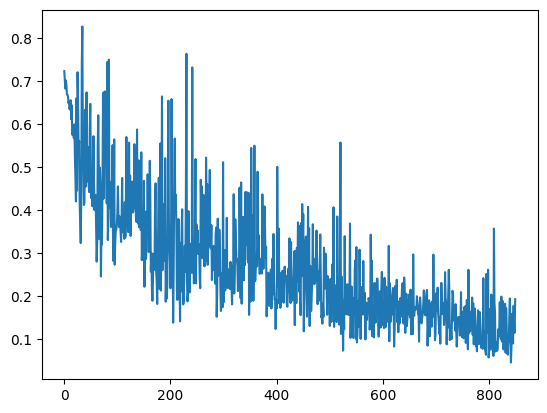

In [108]:
plt.plot(training_loss)

And predict:

In [109]:
def predict(model, test_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    predictions = []
    targets = []

    for x, y, sw in test_loader:
        x, y, sw = x.to(device), y.to(device), sw.to(device)
        outputs = model(x)
        predictions.append(F.softmax(outputs, dim=1))
        targets.append(y)

    return torch.cat(predictions).to('cpu'), torch.cat(targets).to('cpu')

In [110]:
predictions, targets = predict(lstm, test_dl)

In [111]:
cfm = metrics.confusion_matrix(targets, predictions.max(dim=1).indices)
print(f"The confusion matrix is:\n{cfm}")

The confusion matrix is:
[[382  27]
 [  8   5]]


In [112]:
recall = metrics.recall_score(targets, predictions.max(dim=1).indices)
print(f"The recall was {recall*100:.2f}%")

The recall was 38.46%


In [113]:
sensitivity = cfm[1,1]/cfm[1,:].sum()
print(f"The sensitivity is: {sensitivity*100:.2f}%")

The sensitivity is: 38.46%


In [114]:
specificity = cfm[0,0]/cfm[0,:].sum()
print(f"The specificity is: {specificity*100:.2f}%")

The specificity is: 93.40%
